In [1]:
# !pip list

In [2]:
import numpy as np 
import pandas as pd
import os
from tqdm import tqdm 

In [3]:
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model, load_model
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from keras.layers import concatenate, BatchNormalization, Input
from keras.layers.merge import add
from keras.utils import to_categorical
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.utils import plot_model

import matplotlib.pyplot as plt
import cv2
import string
import time
import sys
print("Running.....")

Using TensorFlow backend.


Running.....


In [4]:
token_path = '/kaggle/input/flickr8k/flickr_data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
text = open(token_path, 'r', encoding = 'utf-8').read()
print(text[:500])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7


In [5]:
len(text.split('\n'))//5 

8092

In [6]:
# print(text[:1000])
# print(type(text))
print(text.split('\n')[0].split('\t')[1])

A child in a pink dress is climbing up a set of stairs in an entry way .


In [7]:
def load_description(text):
    mapping = dict()
    for line in text.split("\n"):
        token = line.split("\t")
        if len(line) < 2:
            continue
        img_id = token[0].split('.')[0]
        img_des = token[1]
        if img_id not in mapping:
            mapping[img_id] = list()
        mapping[img_id].append(img_des)
    return mapping

descriptions = load_description(text)
print("Number of items: " + str(len(descriptions)))

Number of items: 8092


In [8]:
descriptions

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

In [9]:
def clean_description(desc):
    for key, des_list in desc.items():
        for i in range(len(des_list)):
            caption = des_list[i]
            caption = [ch for ch in caption if ch not in string.punctuation]
            caption = ''.join(caption)
            caption = caption.split(' ')
            caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()]
            caption = ' '.join(caption)
            des_list[i] = caption

clean_description(descriptions)
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [10]:
def to_vocab(desc):
    words = set()
    for key in desc.keys():
        for line in desc[key]:
            words.update(line.split())
    return words
vocab = to_vocab(descriptions)
len(vocab)

8763

In [11]:
import glob
#same output as os.listdir
images = '/kaggle/input/flickr8k/flickr_data/Flickr_Data/Images/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')
len(img)

8091

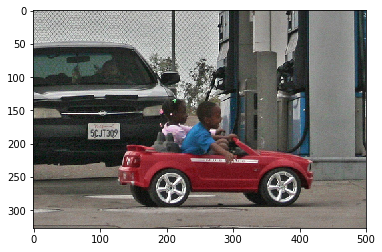

In [12]:
i = plt.imread(img[99])
plt.imshow(i)
del i

In [13]:
from tqdm import tqdm

train_path = '/kaggle/input/flickr8k/flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
train_images = open(train_path, 'r', encoding = 'utf-8').read().split("\n")
train_img = []

for im in tqdm(img):
    if(im[54:] in train_images):
        train_img.append(im)

100%|██████████| 8091/8091 [00:00<00:00, 9999.46it/s] 


In [14]:
test_path = '/kaggle/input/flickr8k/flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
test_images = open(test_path, 'r', encoding = 'utf-8').read().split("\n")
test_img = []

for im in tqdm(img):
    if(im[len(images): ] in test_images):
        test_img.append(im)


100%|██████████| 8091/8091 [00:00<00:00, 39279.96it/s]


In [15]:
# train_img

In [16]:
# test_img

In [17]:
len(train_img), len(test_img)

(6000, 1000)

In [18]:
#load descriptions of train and test set separately
def load_clean_descriptions(des, dataset):
    dataset_des = dict()
    for key, des_list in des.items():
        if key+'.jpg' in dataset:
            if key not in dataset_des:
                dataset_des[key] = list()
            for line in des_list:
                desc = 'startseq ' + line + ' endseq'
                dataset_des[key].append(desc)
    return dataset_des

train_descriptions = load_clean_descriptions(descriptions, train_images)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [19]:
test_descriptions = load_clean_descriptions(descriptions, test_images)
print('Descriptions: train=%d' % len(test_descriptions))

Descriptions: train=1000


In [20]:
# train_features

In [21]:
# train_descriptions

In [22]:
# test_descriptions 

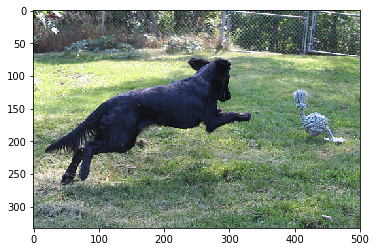

In [23]:
p = '/kaggle/input/flickr8k/flickr_data/Flickr_Data/Images/1107246521_d16a476380.jpg'
img = plt.imread(p)
plt.imshow(img)

In [24]:
base_model = VGG16(weights = 'imagenet')


In [25]:
base_model.layers[-2].output

model_1 = Model(base_model.input, base_model.layers[-2].output)
# base_model.summary()

####  VGG -> 4096 dim., 138 million paramemters, input img_size=(224, 224)
####  InceptionV3 -> 2048dim., 23 million parameters, input img_size=(299,299)

In [26]:
# model_1.save('vgg16_encodings.h5')

In [27]:
from keras.preprocessing.image import load_img, img_to_array
def preprocess_img(img_path):
    #inception v3 accepts img in 299*299
    img = load_img(img_path, target_size = (224, 224))
    x = img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis = 0)
#     x = preprocess_input(x)
    return x

In [28]:
#function to encode an image into a vector using inception v3
def encode(image):
    image = preprocess_img(image)
    vec = model_1.predict(image)
    vec = np.reshape(vec, (vec.shape[1]))
    return vec

In [29]:
from tqdm import tqdm
#each image will be encoded to 4096 dimension vector(as per last layer of model)

#run the encode function on all train images


#--------ENCODING---------

# start = time.time()
# encoding_train = {}
# for img in tqdm(train_img):
#     encoding_train[img[len(images):]] = encode(img)
# print("Time Taken is: " + str(time.time() - start))

# #Encode all the test images
# start = time.time()
# encoding_test = {}
# for img in tqdm(test_img):
#     encoding_test[img[len(images):]] = encode(img)

# print("Time taken is: " + str(time.time() - start))

In [30]:
import pickle
#exporting image encodings
# with open('encoding_train.pickle', 'wb') as handle:
#     pickle.dump(encoding_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
# with open('encoding_test.pickle', 'wb') as handle:
#     pickle.dump(encoding_test, handle, protocol=pickle.HIGHEST_PROTOCOL)    

In [31]:
#importing image encodings
with open('/kaggle/input/image-encodings/image_encoding/image_encoding/encoding_test.pickle', 'rb') as handle:
    encoding_test = pickle.load(handle)
    
with open('/kaggle/input/image-encodings/image_encoding/image_encoding/encoding_train.pickle', 'rb') as handle:
    encoding_train = pickle.load(handle)    

In [32]:
encoding_train = dict(sorted(encoding_train.items()))
encoding_test = dict(sorted(encoding_test.items()))

train_img = sorted(train_img)
test_img = sorted(test_img)

In [33]:
type(encoding_test), type(encoding_train)

(dict, dict)

In [34]:
train_features = encoding_train
test_features = encoding_test

print("Train image encodings: " + str(len(train_features)))
print("Test image encodings: " + str(len(test_features)))

Train image encodings: 6000
Test image encodings: 1000


In [35]:
#list of all training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for caption in val:
        all_train_captions.append(caption)
len(all_train_captions)

30000

In [36]:
#onsider only words which occur atleast 10 times
vocabulary = vocab
threshold = 10
word_counts = {}
for cap in all_train_captions:
    for word in cap.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1
                
vocab = [word for word in word_counts if word_counts[word] >= threshold]
print("Unique words: " + str(len(word_counts)))
print("our Vocabulary: " + str(len(vocab)))

Unique words: 7578
our Vocabulary: 1651


In [37]:
#word mapping to integers
ixtoword = {}
wordtoix = {}

ix = 1
for word in vocab:
    wordtoix[word] = ix
    ixtoword[ix] = word
    ix += 1

In [38]:
vocab_size = len(ixtoword) + 1  #1 for appended zeros
vocab_size

1652

In [39]:
#find the maximum length of a description in a dataset

#max_length of val_captin is 31, so considering 34
max_length = max(len(des.split()) for des in all_train_captions)
max_length

34

In [40]:
train_features

{'1000268201_693b08cb0e.jpg': array([2.5076475, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ], dtype=float32),
 '1001773457_577c3a7d70.jpg': array([0.        , 0.        , 0.49410784, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 '1002674143_1b742ab4b8.jpg': array([1.4937091, 0.       , 0.5356837, ..., 2.315413 , 3.7418406,
        0.       ], dtype=float32),
 '1003163366_44323f5815.jpg': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 '1007129816_e794419615.jpg': array([0.        , 0.09227684, 0.        , ..., 0.        , 0.        ,
        0.06528944], dtype=float32),
 '1007320043_627395c3d8.jpg': array([0.     , 0.     , 0.     , ..., 0.     , 3.33864, 0.     ],
       dtype=float32),
 '1009434119_febe49276a.jpg': array([2.0962934, 2.11932  , 3.5624332, ..., 0.6426386, 2.7146523,
        0.       ], dtype=float32),
 '1012212859_01547e3f17.jpg': array([0.        , 0.        , 0.98737097, ..., 0.        , 1.4932513 ,
        0.8612852 

In [41]:
#since there are almost 30000 descriptions to process we will use datagenerator
X1, X2, y = list(), list(), list()
for key, des_list in train_descriptions.items():
    pic = train_features[key + '.jpg']
    for cap in des_list:
        seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            #store
            X1.append(pic)
            X2.append(in_seq)
            y.append(out_seq)

X1 = np.array(X1)
X2 = np.array(X2)
y = np.array(y)


In [42]:
print(X1.shape) #image encodings
print(X2.shape) #image's caption with padding, maxlength
print(y.shape)  #categorical classes == vocab size

(292328, 4096)
(292328, 34)
(292328, 1652)


In [43]:
#each line from glove txt will be in form
#word (at 0th index) and that particular word's 200d embedding(in the next indexes) 

#load glove vectors for embedding layer
embeddings_index = {}
glove = open('/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt', 'r', encoding = 'utf-8').read()
for line in glove.split("\n"):
    values = line.split(" ")
    word = values[0]
    indices = np.asarray(values[1: ], dtype = 'float32')
    embeddings_index[word] = indices
print('Total word vectors: ' + str(len(embeddings_index)))

Total word vectors: 400001


In [44]:
embeddings_index['plastic'].shape

(200,)

In [45]:
emb_dim = 200
emb_matrix = np.zeros((vocab_size, emb_dim))
for word, i in wordtoix.items():
    emb_vec = embeddings_index.get(word)
    if emb_vec is not None:
        emb_matrix[i] = emb_vec
emb_matrix.shape

(1652, 200)

In [46]:
test_descriptions

{'1056338697_4f7d7ce270': ['startseq blond woman in blue shirt appears to wait for ride endseq',
  'startseq blond woman is on the street hailing taxi endseq',
  'startseq woman is signaling is to traffic as seen from behind endseq',
  'startseq woman with blonde hair wearing blue tube top is waving on the side of the street endseq',
  'startseq the woman in the blue dress is holding out her arm at oncoming traffic endseq'],
 '106490881_5a2dd9b7bd': ['startseq boy in his blue swim shorts at the beach endseq',
  'startseq boy smiles for the camera at beach endseq',
  'startseq young boy in swimming trunks is walking with his arms outstretched on the beach endseq',
  'startseq children playing on the beach endseq',
  'startseq the boy is playing on the shore of an ocean endseq'],
 '1082379191_ec1e53f996': ['startseq lady and man with no shirt sit on dock endseq',
  'startseq man and woman are sitting on dock together endseq',
  'startseq man and woman sitting on dock endseq',
  'startseq

In [47]:
new_descriptions_test = []
new_descriptions_train = []

for key, values in test_descriptions.items():
    v = [i.split()[1:-1] for i in values]
    new_descriptions_test.append(v)
    
for key, values in train_descriptions.items():
    v = [i.split()[1:-1] for i in values]
    new_descriptions_train.append(v)

In [48]:
new_descriptions_train

[[['child',
   'in',
   'pink',
   'dress',
   'is',
   'climbing',
   'up',
   'set',
   'of',
   'stairs',
   'in',
   'an',
   'entry',
   'way'],
  ['girl', 'going', 'into', 'wooden', 'building'],
  ['little', 'girl', 'climbing', 'into', 'wooden', 'playhouse'],
  ['little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse'],
  ['little',
   'girl',
   'in',
   'pink',
   'dress',
   'going',
   'into',
   'wooden',
   'cabin']],
 [['black', 'dog', 'and', 'spotted', 'dog', 'are', 'fighting'],
  ['black',
   'dog',
   'and',
   'tricolored',
   'dog',
   'playing',
   'with',
   'each',
   'other',
   'on',
   'the',
   'road'],
  ['black',
   'dog',
   'and',
   'white',
   'dog',
   'with',
   'brown',
   'spots',
   'are',
   'staring',
   'at',
   'each',
   'other',
   'in',
   'the',
   'street'],
  ['two',
   'dogs',
   'of',
   'different',
   'breeds',
   'looking',
   'at',
   'each',
   'other',
   'on',
   'the',
   'road'],
  ['two', 'dogs', 'on', 'pavement',

In [49]:
new_descriptions_test

[[['blond',
   'woman',
   'in',
   'blue',
   'shirt',
   'appears',
   'to',
   'wait',
   'for',
   'ride'],
  ['blond', 'woman', 'is', 'on', 'the', 'street', 'hailing', 'taxi'],
  ['woman',
   'is',
   'signaling',
   'is',
   'to',
   'traffic',
   'as',
   'seen',
   'from',
   'behind'],
  ['woman',
   'with',
   'blonde',
   'hair',
   'wearing',
   'blue',
   'tube',
   'top',
   'is',
   'waving',
   'on',
   'the',
   'side',
   'of',
   'the',
   'street'],
  ['the',
   'woman',
   'in',
   'the',
   'blue',
   'dress',
   'is',
   'holding',
   'out',
   'her',
   'arm',
   'at',
   'oncoming',
   'traffic']],
 [['boy', 'in', 'his', 'blue', 'swim', 'shorts', 'at', 'the', 'beach'],
  ['boy', 'smiles', 'for', 'the', 'camera', 'at', 'beach'],
  ['young',
   'boy',
   'in',
   'swimming',
   'trunks',
   'is',
   'walking',
   'with',
   'his',
   'arms',
   'outstretched',
   'on',
   'the',
   'beach'],
  ['children', 'playing', 'on', 'the', 'beach'],
  ['the', 'boy', 'is', 

In [50]:
def greedy_search(pic):
    start = 'startseq'
    for i in range(max_length):
        seq = [wordtoix[word] for word in start.split() if word in wordtoix]
#         print('for i',i)
#         print('seq1',seq)
        seq = pad_sequences([seq], maxlen = max_length)
        yhat = model.predict([pic, seq])
        yhat = np.argmax(yhat)
#         print('yhat',yhat)
        word = ixtoword[yhat]
        start += ' ' + word
        if word == 'endseq':
            break
    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
#     print(seq)
    return final  #returns predicted caption

In [51]:
# model = load_model('/kaggle/input/image-encodings/imgcap_model_7epochs.h5')
# model.summary()

In [52]:
# define the model
ip1 = Input(shape = (4096, )) #for image,(input as image embedding)
fe1 = Dropout(0.2)(ip1)
fe2 = Dense(256, activation = 'relu')(fe1)

ip2 = Input(shape = (max_length, ))#for sequences (padded. max length)
se1 = Embedding(vocab_size, emb_dim, mask_zero = True)(ip2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
model = Model(inputs = [ip1, ip2], outputs = outputs)
model.summary()

model.layers[2].set_weights([emb_matrix])
model.layers[2].trainable = False
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
# plot_model(model, to_file = 'model.png', show_shapes = True, show_layer_names = True)



Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [53]:
bleu_score = []

In [54]:
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
chencherry = SmoothingFunction().method1
smoothie = SmoothingFunction().method4


def finding_bleu_score_train():
    global hypothesis_test,hypothesis_train
    hypothesis_test,hypothesis_train = [], []

    for key, values in tqdm(encoding_train.items()):
        temp = greedy_search(values.reshape(1, 4096))
        temp = temp.split()
#         hypothesis_test.append(temp)
        hypothesis_train.append(temp)

    score = corpus_bleu(new_descriptions_train, hypothesis_train,
                        weights=(0.5,0.5), smoothing_function=chencherry)
    print(score)
    return score

def finding_bleu_score_test():
    global hypothesis_test,hypothesis_train
    hypothesis_test,hypothesis_train = [], []

    for key, values in tqdm(encoding_test.items()):
        temp = greedy_search(values.reshape(1, 4096))
        temp = temp.split()
#         hypothesis_test.append(temp)
        hypothesis_test.append(temp)

    score = corpus_bleu(new_descriptions_test, hypothesis_test,
                        weights=(0.5, 0.5), smoothing_function=chencherry)
    print(score)
    return score

In [55]:
epoch = 5
for i in range(1,epoch+1):
    model.fit([X1, X2], y, epochs = 1, batch_size = 256)
#     bleu_score_test.append(finding_bleu_score_test())

Epoch 1/1
292328/292328 [==============================] - 55s 189us/step - loss: 3.9209
Epoch 1/1
292328/292328 [==============================] - 52s 178us/step - loss: 3.1536
Epoch 1/1
292328/292328 [==============================] - 53s 182us/step - loss: 2.9046
Epoch 1/1
292328/292328 [==============================] - 53s 182us/step - loss: 2.7479
Epoch 1/1
292328/292328 [==============================] - 52s 180us/step - loss: 2.6321


In [56]:
model.save('imgcap_model_7epochs.h5')

In [57]:
#train bleu_score
bleu_score.append(finding_bleu_score_train())

100%|██████████| 6000/6000 [12:07<00:00,  8.25it/s]


0.4139474787175353


In [58]:
#test bleu_score
bleu_score.append(finding_bleu_score_test())

100%|██████████| 1000/1000 [02:05<00:00,  7.96it/s]


0.28959896756598


BLEU-2 (2-grams) score observation.

VGG16 model, for 5 epochs
200d test- 0.28, train- 0.39
50d  test- 0.29, train- 0.41
100d test- 0.30 , train- 0.43

InceptionV3 for 5 epochs
200d test-0.17, train-0.17
50d  test-0.17, train- 0.17
100d test- 0.14 , train- 0.14

Bleu score drops after 5 epochs

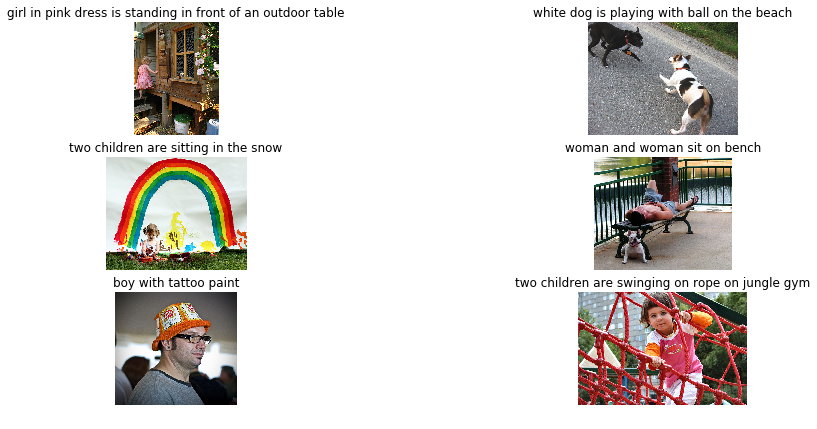

In [59]:
#Visualizing train data

plt.figure(figsize=(16, 12))

for num, val in enumerate(train_img[:6]):
    encoded = encode(val)
    pred_cap = greedy_search(encoded.reshape(1,4096))
    img = plt.imread(val)
    plt.subplot(5,2,num+1)
    plt.title(pred_cap)
    plt.axis('off')
    plt.imshow(img)


ValueError: num must be 1 <= num <= 10, not 11

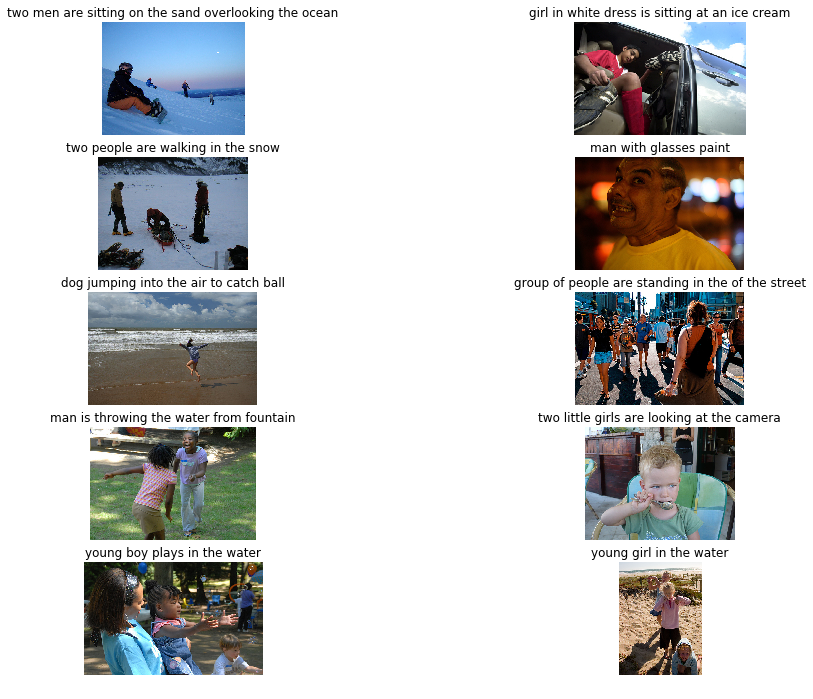

In [60]:
#Visualizing test data

plt.figure(figsize=(16, 12))

for num, val in enumerate(test_img[10:16]):
    encoded = encode(val)
    pred_cap = greedy_search(encoded.reshape(1,4096))
    img = plt.imread(val)
    plt.subplot(5,2,num+1)
    plt.title(pred_cap)
    plt.axis('off')
    plt.imshow(img)

In [ ]:
#Visualizing random raw images

path = '../input/testing-captions3/testing_captioning/'
imgs = os.listdir(path)

plt.figure(figsize=(16, 12))
for num, x in enumerate(imgs):
    encoded = encode(path+imgs[num])
    pred_cap = greedy_search(encoded.reshape(1,4096))
    img = plt.imread(path+x)
    plt.subplot(5,2,num+1)
    plt.title(pred_cap)
    plt.axis('off')
    plt.imshow(img)